In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

import os

In [ ]:
cwd = os.getcwd()
cwd = '/'.join(cwd.split('/')[:-1])

file_path = 'Datasets/home_value_index_co.pkl'

region = 'Boulder'
df = pd.read_pickle(os.path.join(cwd,file_path))

In [4]:
# Filter data for the specific region
region_data = df[df['RegionName'] == region]['home_value_index'].values[0]

# Create a date range
date_range = pd.date_range(start='2000-01-31', freq='M', periods=len(region_data))

# Prepare DataFrame
df_region = pd.DataFrame({'ds': date_range, 'y': region_data})
values = df_region['y'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

# Split into training and testing sets
train_size = int(len(scaled_data) * 0.9)
train, test = scaled_data[:train_size], scaled_data[train_size:]

C:\Users\rishe\AppData\Local\Temp\ipykernel_56888\2657219637.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2000-01-31', freq='M', periods=len(region_data))


In [5]:
look_back = 12
X_train, y_train = [], []
X_test, y_test = [], []

# Prepare training data
for i in range(len(train) - look_back):
    X_train.append(train[i:i + look_back, 0])
    y_train.append(train[i + look_back, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare test data
for i in range(len(test) - look_back):
    X_test.append(test[i:i + look_back, 0])
    y_test.append(test[i + look_back, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape input to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=8, verbose=1)

# Forecast future values
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/500


c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4320e-04
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0105e-04
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5057e-04
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2404e-04
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3046e-04 
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3232e-04 
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6116e-05
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1513e-04
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4148e-05
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1356e-05
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1872e-04
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0544e-05
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7190e-05
Epoch 15/500
32/32 ━━━━━━━━━━

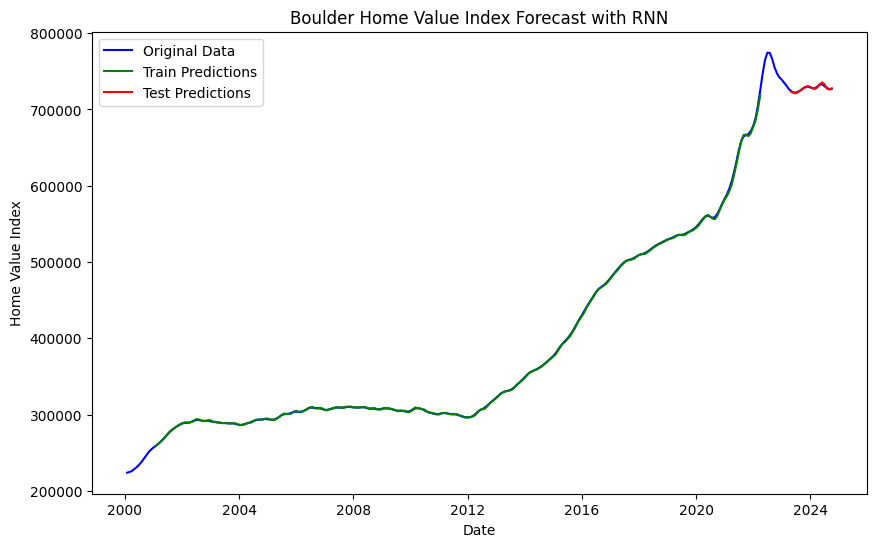


Accuracy Metrics:
MAPE: 0.11%
MAE: 822.74


In [7]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_region['ds'], values, label='Original Data', color='blue')
plt.plot(df_region['ds'][look_back:train_size], predicted_train, label='Train Predictions', color='green')
plt.plot(df_region['ds'][train_size + look_back:], predicted_test, label='Test Predictions', color='red')
plt.title(f'{region} Home Value Index Forecast with RNN')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Calculate accuracy metrics
mape = mean_absolute_percentage_error(y_test_actual, predicted_test) * 100
mae = mean_absolute_error(y_test_actual, predicted_test)

print("\nAccuracy Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")